# Image averaging methods
This notebook implements some methods to image noise reduce by averaging. The noise is made by:

Original image:

![Original image](resources/aar-series.png)

## Results

Noised images average:

![Noised images average](resources/averaged_image.png)

Noised images average after images alignment:

![Noised image average after images alignment](resources/averaged_after_alignment.png)



In [1]:
%matplotlib inline

import glob
import random

import matplotlib.pyplot as plt
from ipykernel.pylab.backend_inline import flush_figures

from skimage import img_as_uint
from skimage.io import imread
from skimage.feature import ORB, match_descriptors, CENSURE
from skimage.transform import downscale_local_mean, ProjectiveTransform
from skimage.transform import warp, SimilarityTransform, rotate
from skimage.measure import ransac
from skimage.util import random_noise
from skimage.exposure import rescale_intensity

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display, clear_output
import ipywidgets as widgets

import numpy as np

import cv2

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'none'
shifted_images = []

for filename in glob.glob('./static_image_series/*.tif'):
    image = rescale_intensity(imread(filename, as_grey=True), in_range=(0, 2**14 - 1), out_range=np.uint16)
    shifted_images.append(image)

## Basic average

This method just average all of the images.

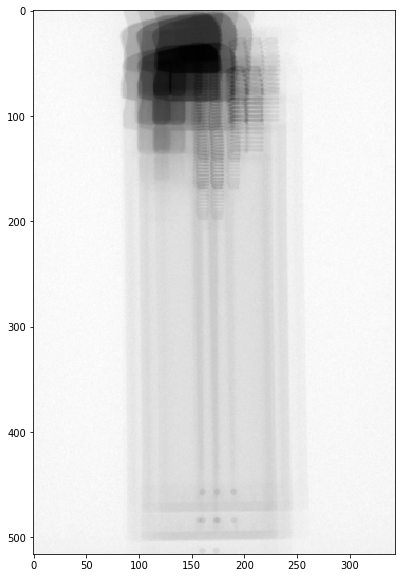

In [2]:
averaged_image = np.mean(shifted_images, axis=0)
plt.figure(figsize=(10,10))
plt.imshow(averaged_image)

# Hybrid Accumulation After Registration Algorithm
This algorythm is based on this paper: https://hal.archives-ouvertes.fr/hal-00510866/document

In my case I've implemented just keypoint and feature detection followed by image matchig and averaging of matched images. I've not implemented searching for the best homography according to the algorithm above.

## Keypoint and feature detection and matching
Following code match keypoints of pairs of images (I0, Ij) where j = 1, ... n, where n is number of images
* This topic is helpful: https://stackoverflow.com/questions/35877193/detecting-similar-points-between-two-pictures-and-then-overlaying-them-python
* Also this implementation of panorama matchich is helpful: https://github.com/scikit-image/scikit-image-paper/blob/master/skimage/pano.txt

Code above finds keypoints of features and setup its binary descriptors.
After keypoint serach it takes all of the keypoints and match them to first image.
Result of this code is array of matched keypoints for all (I0, Ij) pairs  

In [3]:
def intersect_of_point_arrays(a, b):
    return np.array([x for x in set(tuple(x) for x in a) & set(tuple(x) for x in b)])

orb = ORB(n_keypoints=1000)

orb.detect_and_extract(shifted_images[0])
keypoints = orb.keypoints

descriptors = []
keypoints = []
matches_idx = []

descriptors.append(orb.descriptors)
keypoints.append(orb.keypoints)

for image in shifted_images[1:]:
    orb.detect_and_extract(image)
    matches_idx.append(match_descriptors(descriptors[0], orb.descriptors))
    descriptors.append(orb.descriptors)
    keypoints.append(orb.keypoints)

C:\Users\petrc\Anaconda3\lib\site-packages\skimage\feature\match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


# Finding best homography points using RANSAC, warping and averaging
In this part I'm finding an homography points for images pairs 

(I0, Ij) where j = 1, ..., n. n = number of samples

using RANSAC algorithm.
Based on discovered points all of the images are transformed according to first image I0.
After transformation all of the images are averaged.

C:\Users\petrc\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:554: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 0] /= dst[:, 2]
C:\Users\petrc\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:555: RuntimeWarning: invalid value encountered in true_divide
  dst[:, 1] /= dst[:, 2]
C:\Users\petrc\Anaconda3\lib\site-packages\skimage\measure\fit.py:931: RuntimeWarning: invalid value encountered in less
  sample_model_inliers = sample_model_residuals < residual_threshold
C:\Users\petrc\Anaconda3\lib\site-packages\skimage\transform\_geometric.py:555: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 1] /= dst[:, 2]


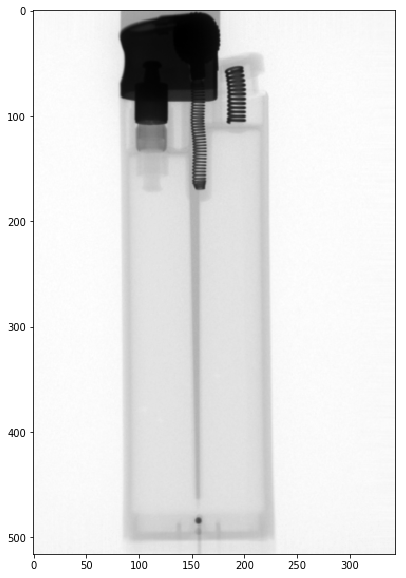

In [4]:
number_of_agreed = 0
random_points = []

warped_images = []

for idx, image in enumerate(shifted_images[1:]):
    src = keypoints[idx + 1][matches_idx[idx][:, 1]][:, ::-1]
    dst = keypoints[0][matches_idx[idx][:, 0]][:, ::-1]
    model_robust, inliers = ransac((src, dst), 
                                   ProjectiveTransform,
                                   min_samples=4,
                                   residual_threshold=2)
    
    # wrap image
    y, x = image.shape[:2]
    corners = np.array([[0, 0], [0, y], [x, 0], [x, y]])
    warped_corners = model_robust(corners)
    
    warped_images.append(warp(image, model_robust.inverse, mode='edge'))

plt.figure(figsize=(10, 10))
plt.imshow(np.mean(warped_images, axis=0))
    